# 第5章 ロジスティック回帰とROC曲線：学習モデルの評価方法

## 「05-logistic_vs_perceptron」の解説

ITエンジニアための機械学習理論入門「第5章 ロジスティック回帰とROC曲線:学習モデルの評価方法」で使用しているサンプルコード「05-logistic_vs_perceptron.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

関数 multivariate_normal は、多次元の正規分布に従う乱数を生成するために利用します。

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal

トレーニング用データを生成する関数を用意します。

平面上の○☓の2種類のデータについて、それぞれの「個数、中心座標、分散」を引数で指定します。

In [0]:
def prepare_dataset(n1, mu1, variance1, n2, mu2, variance2):
    df1 = DataFrame(multivariate_normal(mu1, np.eye(2)*variance1 ,n1),
                    columns=['x','y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(mu2, np.eye(2)*variance2, n2),
                    columns=['x','y'])
    df2['type'] = -1
    df = pd.concat([df1,df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

パーセプトロンで分割線を決定する関数を用意します。

In [0]:
# パーセプトロン
def run_perceptron(train_set):
    # パラメータの初期値とbias項の設定
    w0 = w1 = w2 = 0.0
    bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())

    # Iterationを実施
    paramhist = DataFrame([[w0,w1,w2]], columns=['w0','w1','w2'])
    for i in range(30):
        for index, point in train_set.iterrows():
            x, y, type = point.x, point.y, point.type
            if type * (w0*bias + w1*x + w2*y) <= 0:
                w0 += type * bias
                w1 += type * x
                w2 += type * y
    
    # 判定誤差の計算
    err = 0.0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        if type * (w0*bias + w1*x + w2*y) <= 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    return w0, w1, w2, err_rate

同じく、ロジスティック回帰で分割線を決定する関数を用意します。

In [0]:
# ロジスティック回帰
def run_logistic(train_set):
    w = np.array([[0],[0.1],[0.1]])
    phi = train_set[['x','y']]
    phi['bias'] = 1
    phi = phi.as_matrix(columns=['bias','x','y'])
    t = (train_set[['type']] + 1)*0.5 # type = 1, -1 を type = 1, 0 に変換
    t = t.as_matrix()

    # 最大30回のIterationを実施
    for i in range(30):
        # IRLS法によるパラメータの修正
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0/(1.0+np.exp(-a))])
        r = np.diag(y*(1-y)) 
        y = y[np.newaxis,:].T
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, r),phi))
        tmp2 = np.dot(phi.T, (y-t))
        w_new = w - np.dot(tmp1, tmp2)
        # パラメータの変化が 0.1% 未満になったら終了
        if np.dot((w_new-w).T, (w_new-w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new
        
    # 分類誤差の計算
    w0, w1, w2 = w[0], w[1], w[2]
    err = 0.0
    for index, point in train_set.iterrows():
        x, y, type = point.x, point.y, point.type
        type = type * 2 - 1
        if type * (w0 + w1*x + w2*y) < 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    return w0, w1, w2, err_rate

結果をグラフに表示する関数を用意します。

In [0]:
# 結果の表示
def show_result(subplot, train_set, w0, w1, w2, err_rate):
    train_set1 = train_set[train_set['type']==1]
    train_set2 = train_set[train_set['type']==-1]
    ymin, ymax = train_set.y.min()-5, train_set.y.max()+10
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10

    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    subplot.scatter(train_set1.x, train_set1.y, marker='o', label=None)
    subplot.scatter(train_set2.x, train_set2.y, marker='x', label=None)

    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    subplot.plot(linex, liney, label=label, color='red')
    subplot.legend(loc=1)

トレーニングセットを用意します。

In [0]:
train_set = prepare_dataset(20, [15,10], 10, 30, [0,0], 10)

パーセプトロンでトレーニングした結果を表示します。

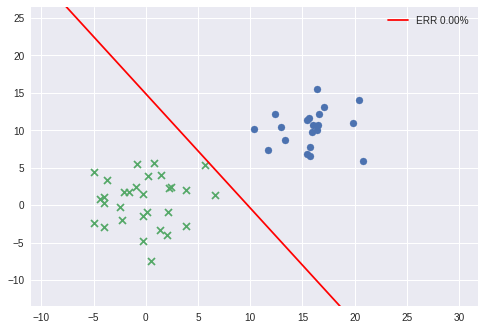

In [7]:
w0, w1, w2, err_rate = run_perceptron(train_set)
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())
show_result(subplot, train_set, w0*bias, w1, w2, err_rate)

同じトレーニングセットについて、ロジスティック回帰でトレーニングした結果を表示します。

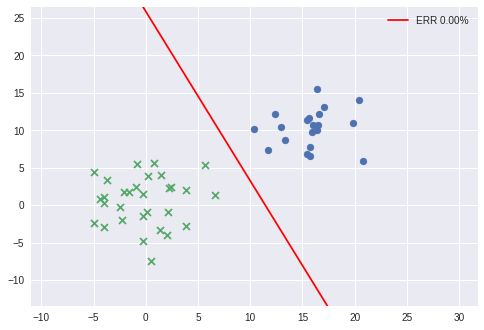

In [8]:
w0, w1, w2, err_rate = run_logistic(train_set)
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
show_result(subplot, train_set, w0, w1, w2, err_rate)